# Reuters Clustering Example

## Load data

In [ ]:
# Install transformers
!pip install transformers

In [ ]:
# Import libraries

# Main
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# NLP
from gensim.parsing.porter import PorterStemmer
from gensim.parsing.preprocessing import remove_stopwords

import nltk
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Transformers
from transformers import AutoTokenizer, TFAutoModel

# Sklearn
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from IPython.display import clear_output

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Tweets

In [ ]:
def data_loader(lang, source, total_data=None):
    """ Function to retrieve tweet data in specified language
    Args:
        lang (str): Language to load tweets in [en, es, fr]
    Returns:
        list: tweets list
    """
    path = os.path.join(self.path_prefix, source, lang)
    files_list = os.listdir(path)
    data = []
    for file in tqdm(files_list):
        with open(os.path.join(path, file), 'r+') as file_str:
            data_dict = json.load(file_str)
            data.append(data_dict['text'])
    if total_data == None:
        return data
    else:
        return random.sample(data, total_data)

In [ ]:
data = data_loader('en', 'MyDrive/NLP/Twitter', total_data=50000)

### Reuters Dataset

In [ ]:
# Download data set
try:
  from nltk.corpus import reuters
except:
  nltk.download('reuters')
  !unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora
  from nltk.corpus import reuters

In [ ]:
# Extract dataset
raw_data = []
raw_labels = []
for file in reuters.fileids():
  raw_data.append(reuters.raw(file))
  raw_labels.append(reuters.categories(file))

In [ ]:
# let's consider only 5 categories
our_labels = ['crude', 'coffee', 'grain', 'gold']

# def arrays
data = []
labels = []

# Extract only 5 categories
for i in range(len(raw_labels)):
    if any(item in raw_labels[i] for item in our_labels) and len(raw_data[i].split())<300:
        data.append(raw_data[i])
        labels.append(raw_labels[i])

In [ ]:
# Code labels to just one number
new_labels = []
for label in labels:
    for i, our_lb in enumerate(our_labels):
      if our_lb in label :
        new_labels.append(i)
        break

In [ ]:
len(new_labels)

1164

## Preprocessing

In [ ]:
# Colloquial dict contractions
contraction_colloq_dict = {"btw": "by the way", "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "where's":"where is"}

# Process text
def process_text(text, tokenizer, lemmatizer):
    """ Applies standard pre-processing to given text.
    
    Args:
        p (gensim.parsing.porter.PorterStemmer): stemmer object.
        tokenizer (nltk.tokenize.regexp.RegexpTokenizer): tokenizr object.
        text (str): text to preprocess.
    
    Returns:
        list: preprocessed text.
    
    """
    # Converts to lowercase
    text_lc = text.lower()
    
    # Replace colloquial terms
    for word in text_lc.split():
        if word in list(contraction_colloq_dict.keys()):
            text_lc = text_lc.replace(word, contraction_colloq_dict[word])
    
    # Removes stopwords
    text_sw = remove_stopwords(text_lc)
    
    # Stems text
    #text_stem = p.stem_sentence(text_sw)
    
    # Tokenizes text and removes punctuation
    #text_tk = tokenizer.tokenize(text_lc)
    
    # Lemmatizes text
    #text_lm = []
    #for word in text_tk:
    #    text_lm.append(lemmatizer.lemmatize(word))
         
    # Returns preprocessed text
    return text_sw

In [ ]:
# Creates lemmatizer instance
lemmatizer = nltk.stem.WordNetLemmatizer()
# Creates RegexpTokenizer (removes punctuation signs)
tk = nltk.RegexpTokenizer(r'\w+')

corpus = []
for d in data:
  corpus.append(process_text(d, tk, lemmatizer))

## BERT Embedding

In [ ]:
# Bert instance
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#model = TFAutoModel.from_pretrained("distilbert-base-uncased", output_hidden_states=True)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Test Model for first sentence
inputs = tokenizer(corpus[0], padding='max_length', return_tensors="tf")
outputs = model(**inputs)

# Just pooler output as embeddings
embedding = outputs['pooler_output'][0].numpy()

In [ ]:
# Array to save embeddings
reu_embeddings = []

for i, doc in enumerate(corpus):
  # Run Bert for each document
  inputs = tokenizer(doc, return_tensors="tf")
  outputs = model(**inputs)

  # CLS Token
  embedding = outputs['pooler_output'][0].numpy()

  # Sum of all layers
#  embedding = tf.reshape(outputs['hidden_states'][-1], 512*768).numpy()
#  for hs in range(2,8):
#    embedding += tf.reshape(outputs['hidden_states'][-hs], 512*768).numpy()

  reu_embeddings.append(embedding)
  print(f'Tokenizing Doc {i}')
  clear_output(wait=True)

Tokenizing Doc 1163


## Autoencoder

In [ ]:
# Declare autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.models.Sequential()
    self.encoder.add(tf.keras.Input(shape=(768,)))
    #self.encoder.add(layers.Dense(300, activation='relu'))
    self.encoder.add(layers.Dense(latent_dim, activation='linear'))

    #self.encoder = tf.keras.Sequential([
    #  layers.Dense(latent_dim, activation='relu', input_shape = (768,))
    #])

    self.decoder = tf.keras.models.Sequential()
    #self.decoder.add(layers.Dense(300, activation='relu'))
    self.decoder.add(tf.keras.layers.Dense(768, activation='linear'))

    #self.decoder = tf.keras.Sequential([
    #  layers.Dense(768, activation='linear')
    #])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [ ]:
# Compile autoencoder
latent_dim = 32
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Train
autoencoder.fit(np.asarray(reu_embeddings), np.asarray(reu_embeddings), epochs=15, shuffle=True)

Epoch 1/15
37/37 [==============================] - 0s 2ms/step - loss: 0.2781
Epoch 2/15
37/37 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 3/15
37/37 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 4/15
37/37 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 5/15
37/37 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 6/15
37/37 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 7/15
37/37 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 8/15
37/37 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 9/15
37/37 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 10/15
37/37 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 11/15
37/37 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 12/15
37/37 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 13/15
37/37 [==============================

In [ ]:
encoded_reu = autoencoder.encoder(np.asarray(reu_embeddings)).numpy()

## Clustering

In [ ]:
# Principal component analysis for dim reduction (optional)
pca = PCA(n_components=2)
X = pca.fit_transform(encoded_reu)

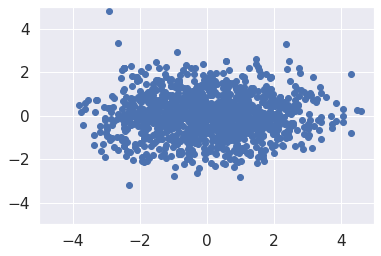

In [ ]:
plt.scatter(X[:,0],X[:,1])
plt.ylim([-5, 5])
plt.xlim([-5, 5])
plt.grid(True)
plt.show()

In [ ]:
# K MEANS CLUSTERING
k_means = KMeans(4, max_iter = 300)
clusters_kmeans = k_means.fit_predict(encoded_reu)

In [ ]:
# AGGLOMERATIVE CLUSTERING
agg_clustering = AgglomerativeClustering(n_clusters=4)#, linkage='average', affinity='cosine')
clusters_agg = agg_clustering.fit_predict(encoded_reu)

In [ ]:
# SPECTRAL CLUSTERING
spectral_clustering = SpectralClustering(n_clusters=4, assign_labels='discretize')
clusters_spec = spectral_clustering.fit_predict(encoded_reu)

In [ ]:
dbscan_clustering = DBSCAN(eps=3, min_samples=4)
clusters_dbscan = dbscan_clustering.fit_predict(bert_embeddings)

## Results

### Key Words (Just for K-Means)

In [ ]:
from scipy.spatial import distance

def get_relevant_docs_from_clusters(clustering, embeddings, n_relevant_docs=5):
  
  # Init relevant docs list
  relevant_docs_id = []

  # Get cluster and centers
  centers = clustering.cluster_centers_
  clusters = clustering.labels_

  emb_distances = []

  # Loop around doc embeddings
  for i, emb in enumerate(embeddings):
    # Compute distance between embedding and cluster center
    emb_distances.append(distance.pdist([emb, centers[clusters[i]]]).item(0))

  # Sort distances
  sorted_index = np.argsort(emb_distances)
  emb_distances = np.array(emb_distances)[sorted_index[::-1]]
  clusters = np.array(clusters)[sorted_index[::-1]]

  # Select n relevant docs for each cluster
  for i in range(clustering.n_clusters):
    relevant_docs_cluster = []
    
    for j, dist in enumerate(emb_distances):
      #print(dist)
      if i == clusters[j]:
        relevant_docs_cluster.append(sorted_index[j])

      if len(relevant_docs_cluster) > n_relevant_docs:
        break
    relevant_docs_id.append(relevant_docs_cluster)

  return relevant_docs_id

In [ ]:
from collections import Counter

docs_id = get_relevant_docs_from_clusters(k_means, encoded_reu, n_relevant_docs=10)

for i, docs in enumerate(docs_id):

  tokens = []

  for id in docs:
    # split() returns list of all the words in the string
    tokens = tokens + corpus[id].split()
    
  # Pass the split_it list to instance of Counter class.
  key_words = Counter(tokens)
  print(f'Cluster {i}: {key_words}')

Cluster 0: Counter({'oil': 23, 'said.': 22, 'said': 16, 'u.s.': 11, 'grain': 10, 'exploration': 10, 'dlrs': 8, 'year': 7, 'saudi': 7, 'minus': 7, 'officials': 6, 'agreement': 6, 'usda': 6, 'wheat': 6, 'production': 6, 'open': 6, 'pct': 6, 'elevator': 5, 'export': 5, 'meeting': 5, 'new': 5, 'offer': 5, 'gold': 5, 'april': 5, 'corp': 5, 'foreign': 5, 'mobil': 5, 'crude': 5, 'levy': 5, 'president': 5, 'reagan': 5, 'opec': 5, 'summer': 4, 'subsidy': 4, 'mln': 4, 'boliden': 4, 'output': 4, '70': 4, 'amoco': 4, 'government': 4, 'australian': 4, 'story': 4, 'higher': 4, 'cts': 4, 'traders': 4, 'explosion': 3, 'according': 3, 'prices': 3, 'tonne': 3, 'department': 3, 'petroleum': 3, "boliden's": 3, 'jordan': 3, 'bids': 3, 'soft': 3, 'hard': 3, 'madagascar': 3, 'extended': 3, 'statement': 3, 'plans': 3, 'office': 3, 'tax': 3, 'maximum': 3, 'bass': 3, '80': 3, 'week': 3, 'points': 3, 'peking': 3, 'china': 3, 'reliance': 3, 'administration': 3, 'energy': 3, 'heating': 3, 'iowa': 2, 'today': 2, 'c

### Plots

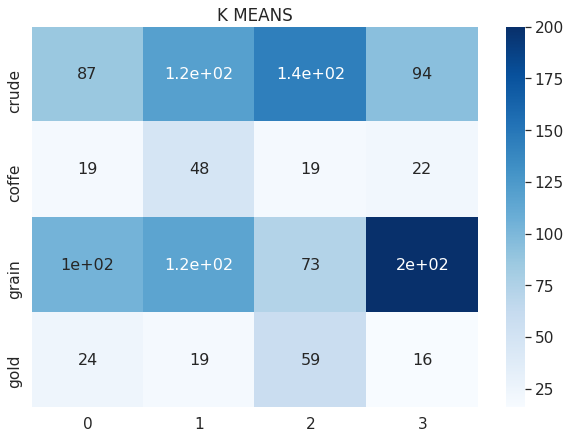

In [ ]:
import seaborn as sn

# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_kmeans)

# Plot
df_cm = pd.DataFrame(matrix,['crude', 'coffe', 'grain', 'gold'], range(4))
plt.figure(figsize=(10,7))
plt.title('K MEANS')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()

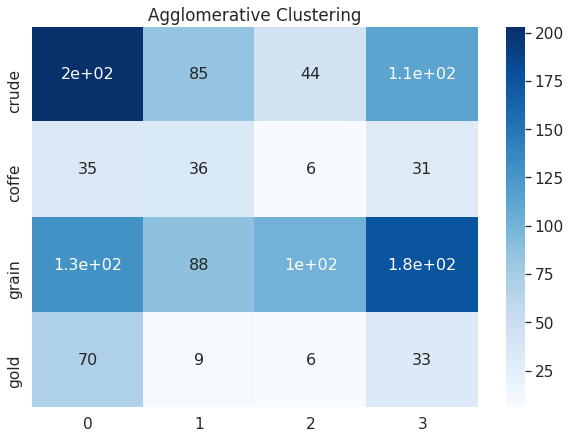

In [ ]:
# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_agg)

# Plot
df_cm = pd.DataFrame(matrix,['crude', 'coffe', 'grain', 'gold'], range(4))
plt.figure(figsize=(10,7))
plt.title('Agglomerative Clustering')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()

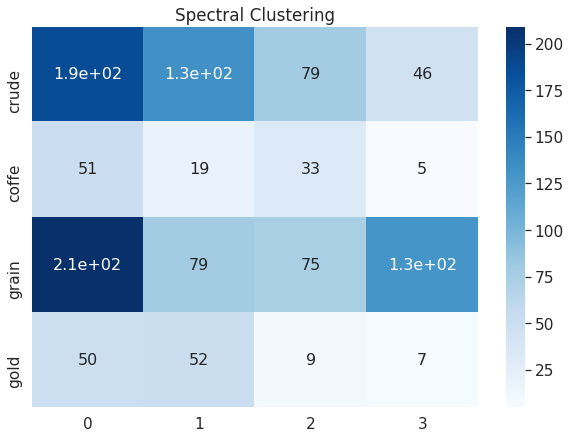

In [ ]:
# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_spec)

# Plot
df_cm = pd.DataFrame(matrix, ['crude', 'coffe', 'grain', 'gold'], range(4))
plt.figure(figsize=(10,7))
plt.title('Spectral Clustering')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()

In [ ]:
# Confusion Matrix
matrix = confusion_matrix(new_labels, clusters_dbscan)

n_clusters = len(np.unique(clusters_dbscan))

# Plot
df_cm = pd.DataFrame(matrix)#, ['crude', 'jobs','grain', 'gold', 'coffee'], range(5))
plt.figure(figsize=(10,7))
plt.title('DBSCAN Clustering')
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

plt.show()

In [ ]:
matrix